## Qual o próximo hit do Spotify?

Regras:

1. Limpeza e tratamento de valores nulos        (0,5pt)
2. Codificação de variáveis categóricas         (0,5pt)
3. Exploração e visualização de dados           (2,0pt)
4. Formulação de hipóteses                      (1,0pt)
5. Seleção de features                          (1,0pt)
6. Construção e avaliação do modelo             (2,0pt)
7. Finetuning de hiperparâmetros                (1,0pt)
8. Acurácia mínima                              (2,0pt)
9. Documentação e apresentação dos resultados   (2,0pt)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
# Carregamentos dos dados
musicas_train = pd.read_csv('./data/train.csv')
musicas = pd.read_csv('./data/test.csv')

## Limpeza de dados e tratamento de outliers

Identificação de colunas com valores nulos e separação do dataset, removendo variáveis categóricas ou sem importância para o treinamento do modelo.

In [3]:
# Remover duplicatas com base na coluna 'track_id', mantendo a primeira ocorrência
musicas_train = musicas_train.drop_duplicates(subset='track_id', keep='first')

# Exibir quantas linhas restaram no DataFrame após remover duplicatas
print(f"Número de músicas após remover duplicatas: {musicas_train.shape[0]}")

Número de músicas após remover duplicatas: 66720


In [4]:
# Limpeza de dados nulos
print(musicas.isnull().sum())

track_unique_id     0
track_id            0
artists             1
album_name          1
track_name          1
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


In [5]:
musicas.dtypes

track_unique_id       int64
track_id             object
artists              object
album_name           object
track_name           object
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object

In [6]:
# Definição dos limites de cada coluna
for coluna, valores in musicas.describe().items():
    z_score = norm.interval(confidence = 0.90, loc = valores['mean'], scale = valores['std'])
    print(f"{coluna}:               {z_score}")

track_unique_id:               (2867.048265808102, 110473.97951196966)
duration_ms:               (43530.826420274505, 413119.9626440529)
danceability:               (0.2784924326107346, 0.8526900176816627)
energy:               (0.2269708230643604, 1.055111815900552)
key:               (-0.5332534561692173, 11.16132363160781)
loudness:               (-16.496702909882806, 0.0010901028652590128)
mode:               (-0.15376628105859225, 1.4280352869065451)
speechiness:               (-0.08978308921310219, 0.25862870909614305)
acousticness:               (-0.232248252010621, 0.8617489980691002)
instrumentalness:               (-0.3512808017024528, 0.6574545474340315)
liveness:               (-0.10019153108444784, 0.5284185193885412)
valence:               (0.046190935285959134, 0.9010191811467891)
tempo:               (72.86588121822459, 171.7624232262198)
time_signature:               (3.202332965604437, 4.612637794629481)


In [7]:
musicas_numeric = musicas.select_dtypes(include=['int64', 'float64'])

# Identificação e tratamento dos outliers
for musica in musicas_numeric:
    limite_inferior = musicas_numeric.quantile(0.05)
    limite_superior = musicas_numeric.quantile(0.95)
    
    musicas_numeric = musicas_numeric.mask(musicas_numeric < limite_inferior, limite_inferior, axis=1)
    musicas_numeric = musicas_numeric.mask(musicas_numeric > limite_superior, limite_superior, axis=1)

musicas.update(musicas_numeric)

## Codificação de variáveis categóricas

Após a separação das variáveis que podem ser utilizadas para treinar o modelo, resta codificar algumas variáveis categóricas que podem ser importantes, foram separadas as seguintes variáveis para codificação:

- Artista (artists)

O nome do artista foi substituído por um valor numérico, o critério para o valor numérico é correspondente a quantidade de músicas do artista que aparece na lista.

- Nome do álbum (album_name)

O nome do álbum foi substituído por um valor numérico, o critério para o valor numérico é correspondente a quantidade de músicas do álbum que aparece na lista.

- Gênero musical (track_genre)

O gênero musical foi substituído por um valor numérico, o critério para o valor numérico é correspondente a quantidade de músicas que pertecem a cada gênero musical.

- É explicito? (explicit)
  
Ao analisar o dataset do spotify, é coerente apontar que músicas não explícitas são mais ouvidas. 
(Isso é explicado mais a fundo na hipótese 1)

Sendo assim, é válido afirmar que músicas não explicítas tem maior probabilidade de serem populares, logo será dado o valor 1 para músicas não explicítas e o valor 0 para músicas explicítas.

In [8]:
# Codificação da variável de nome do artista
artist_counts = musicas_train['artists'].value_counts()
musicas_train['artists'] = musicas_train['artists'].map(artist_counts)
artist_counts = musicas['artists'].value_counts()
musicas['artists'] = musicas['artists'].map(artist_counts)

# Codificação da variável de nome do álbum
album_counts = musicas_train['album_name'].value_counts()
musicas_train['album_name'] = musicas_train['album_name'].map(album_counts)
album_counts = musicas['album_name'].value_counts()
musicas['album_name'] = musicas['album_name'].map(album_counts)

# Codificação da variável de gênero musical
genre_counts = musicas_train['track_genre'].value_counts()
musicas_train['track_genre'] = musicas_train['track_genre'].map(genre_counts)
genre_counts = musicas['track_genre'].value_counts()
musicas['track_genre'] = musicas['track_genre'].map(genre_counts)

# Codificação da variável Explicito
musicas_train['explicit'] = musicas_train['explicit'].apply(lambda x: 0 if x else 1)
musicas['explicit'] = musicas['explicit'].apply(lambda x: 0 if x else 1)

## Exploração e Visualização dos dados

In [9]:
musicas.describe()

,track_unique_id,artists,album_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
count,34200.000000,34199.000000,34199.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000
mean,56676.974181,8.210328,4.745490,223627.686930,0.914942,0.566965,0.644201,5.314035,-7.997306,0.637135,0.075561,0.313220,0.151496,0.206851,0.473270,122.245122,3.912076,300.716082
std,32229.663571,12.836475,7.525807,70064.861295,0.278973,0.162292,0.242325,3.554899,4.008464,0.480834,0.063463,0.329530,0.302580,0.164721,0.254426,28.100092,0.283188,14.652220
min,5823.000000,1.000000,1.000000,115560.000000,0.000000,0.246000,0.156000,0.000000,-17.956000,0.000000,0.028200,0.000138,0.000000,0.060000,0.070400,77.467000,3.000000,262.000000
25%,28612.500000,1.000000,1.000000,173325.000000,1.000000,0.455000,0.472000,2.000000,-10.039000,0.000000,0.035800,0.016600,0.000000,0.098200,0.256000,99.537500,4.000000,291.000000
50%,56475.500000,3.000000,2.000000,213177.500000,1.000000,0.579000,0.683000,5.000000,-6.984000,1.000000,0.048700,0.168500,0.000043,0.133000,0.463000,122.052500,4.000000,301.000000
75%,84855.750000,9.000000,4.000000,261672.000000,1.000000,0.693000,0.853000,8.000000,-5.011000,1.000000,0.084700,0.597000,0.045800,0.273000,0.682000,140.204000,4.000000,312.000000
max,108100.000000,86.000000,64.000000,387306.000000,1.000000,0.824000,0.970000,11.000000,-2.944000,1.000000,0.265000,0.946000,0.904000,0.682000,0.912000,175.417000,4.000000,342.000000


Gráfico Heatmap de correlações entre as variáveis numéricas

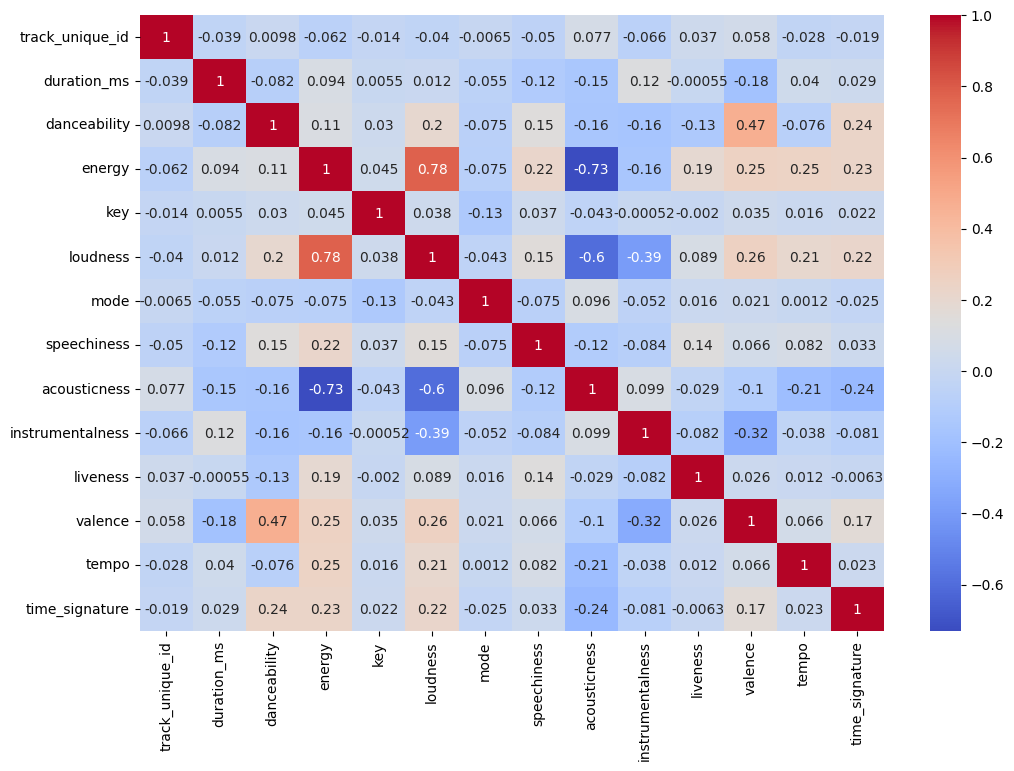

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(musicas_numeric.corr(), annot=True, cmap='coolwarm')
plt.show()


Histograma demonstrando a distribuição de valores de cada variável numérica.

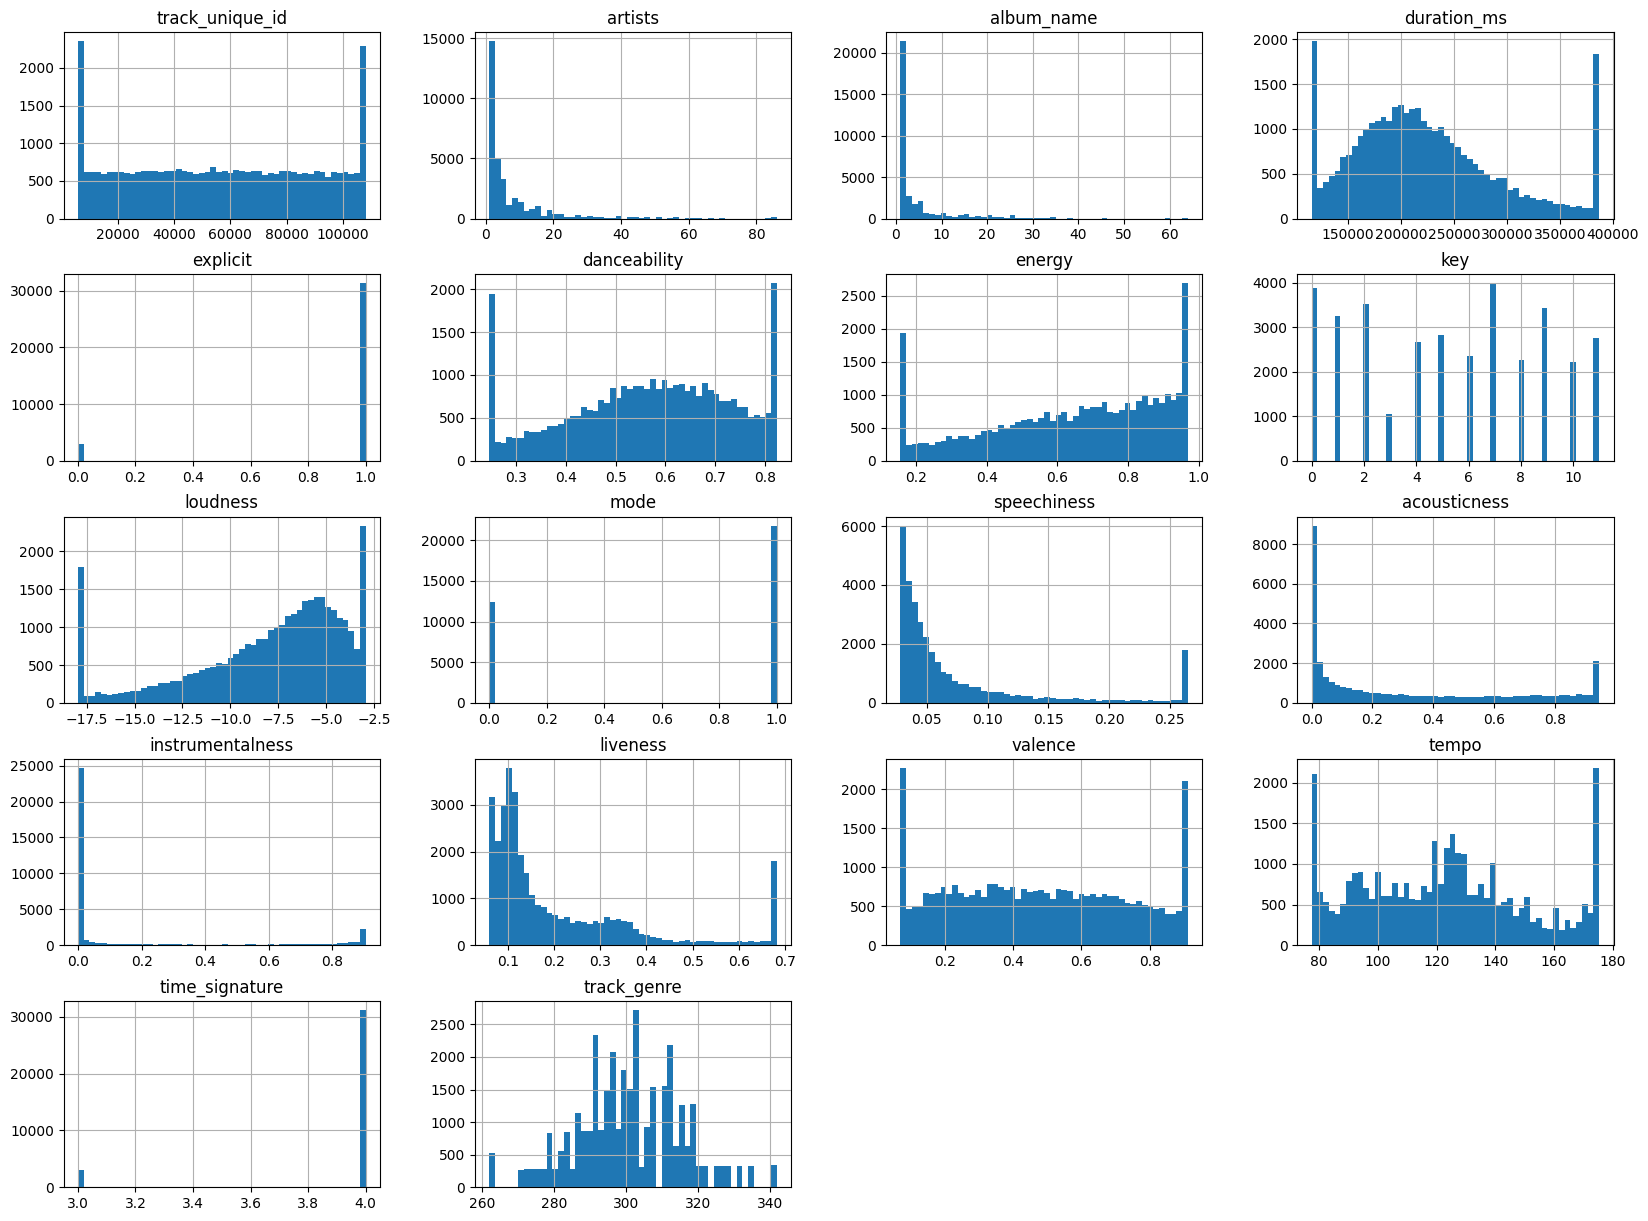

In [11]:
musicas.hist(bins=50, figsize=(20, 15))
plt.show()

## Formulação de Hipóteses

### 1° Hipótese - Músicas não explícitas tem maior probabilidade de serem populares

Ao analisar o dataset do Spotify, chegamos a conclusão de que, historicamente, músicas não explícitas atingem um público maior e possuem maior tendência de se posicionarem entre as músicas mais populares, assim como descrito no gráfico a seguir:

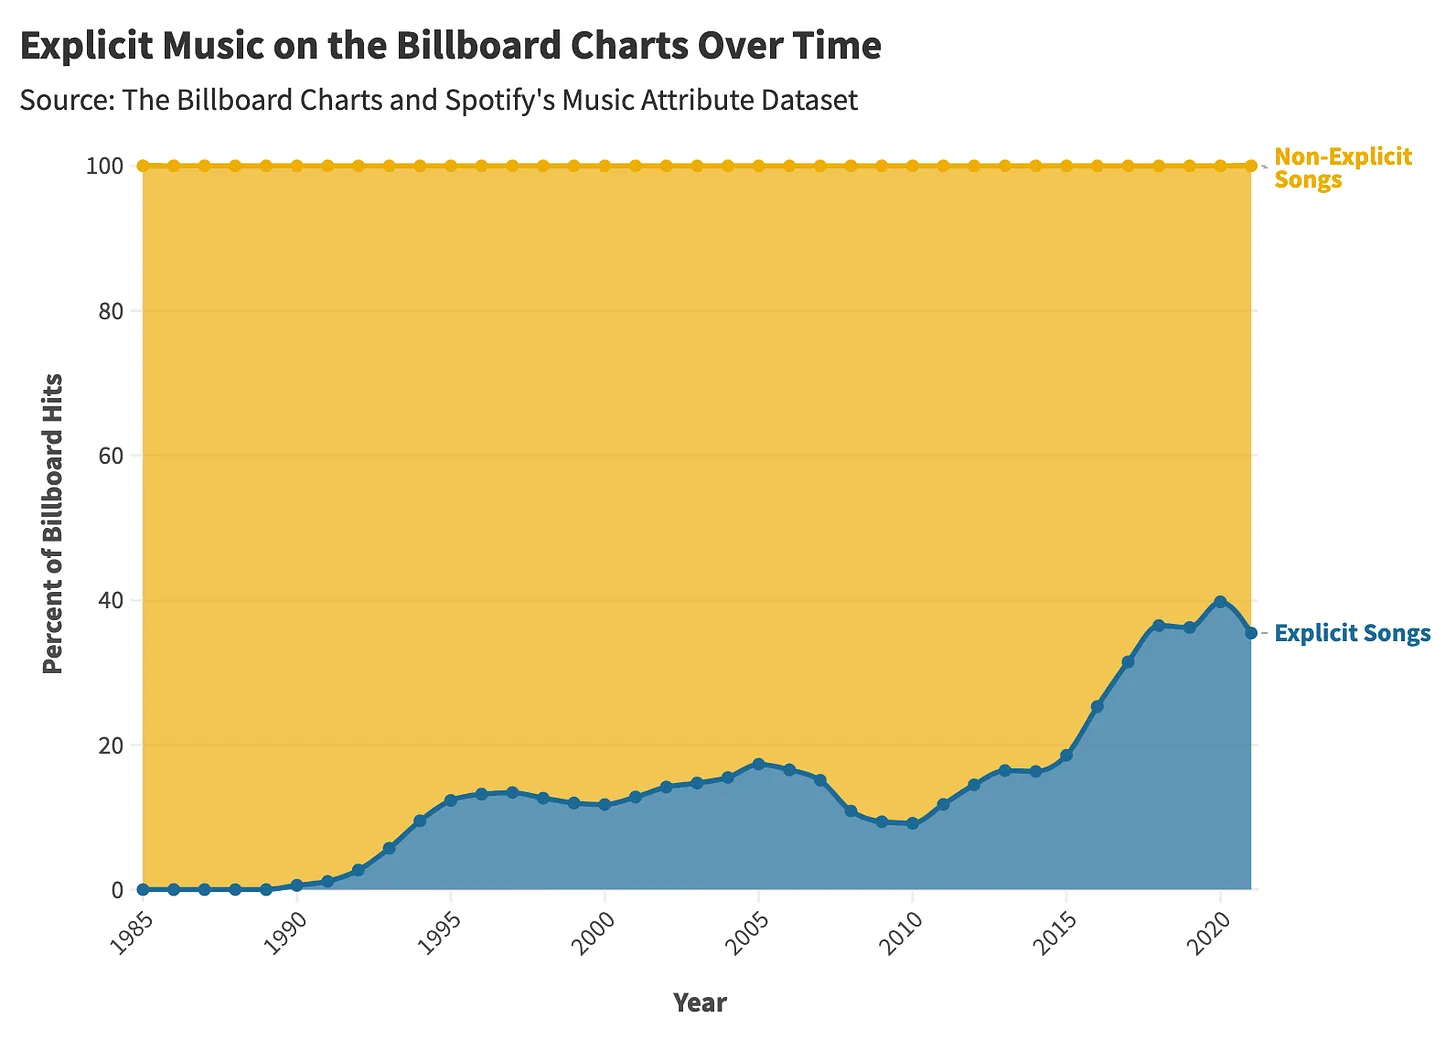

Fonte: [Stat Significant - The Rise of Explicit Music: A Statistical Analysis.](https://www.statsignificant.com/p/the-rise-of-explicit-music-a-statistical)

O gráfico busca estabelecer uma relação entre a quantidade de músicas explícitas e não explícitas entre as músicas mais populares do momento nos charts da Billboard. Demonstrando que, atualmente, pouco mais de 60% das músicas que estão entre as mais populares do momento são músicas não explícitas.

### 2° Hipótese - Músicas de gêneros específicos têm maior probabilidade de serem populares

Após a analisar os dados, é válido apontar que, quando uma música se encaixa em gêneros músicais específicos, ela possui maiores chances de se tornar popular.

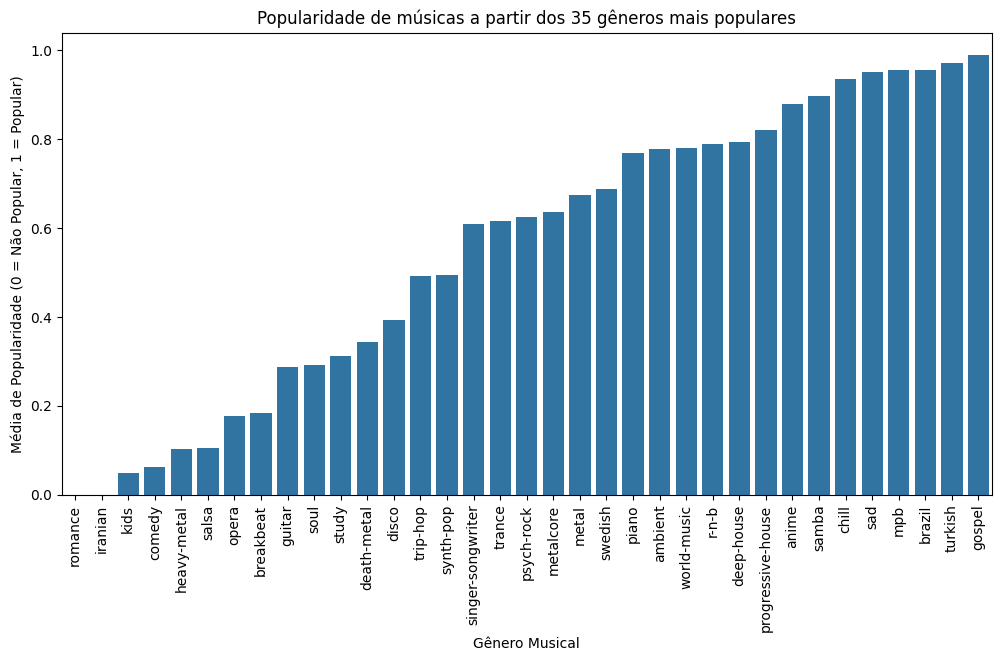

Fonte: Material produzido pelo autor

O gráfico demonstra como gêneros específicos possuem maior popularidade, isso pode acontecer com diversos gêneros músicais, e é observado principalmente em músicas religiosas, como músicas gospel, atreladas ao cristianismo,e em gêneros músicais culturais de alguma nação, como a MPB (Música Popular **Brasileira**).

### 3° Hipótese - Músicas com menor presença de palavras faladas (baixo speechiness) possuem maior probabilidade de serem populares

Músicas com mais melodia (menos palavras faladas) são mais agradáveis para o público em geral, resultando em maior popularidade.

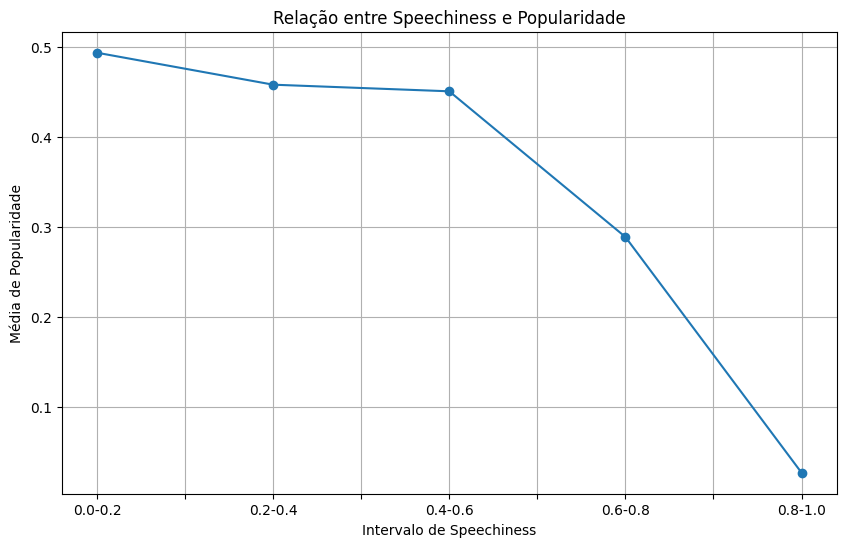

Fonte: Material produzido pelo autor

Ao analisar o gráfico, é possível perceber que quanto maior a presença de palavras faladas, diminuindo a quantidade de músicas populares por nível de speechiness a partir do valor 0.4, criando uma descidade na popularidade forma praticamente linear.

## Seleção de features

Features selecionadas:

- artists (codificada)
- album_name (codificada)
- duration_ms
- explicit (codificada)
- danceability
- energy
- key
- loudness
- mode
- speechiness
- acousticness
- instrumentalness
- liveness
- valence
- tempo
- time_signature
- track_genre (codificada)

Features excluídas:

- track_unique_id
  - Feature de identificação, tornando seu valor irrelevante no cálculo de probabilidade da música
- track_id
  - Feature de identificação, tornando seu valor irrelevante no cálculo de probabilidade da música
- track_name
  - Feature sem padrão de organização, se tornando irrelevante.

In [12]:
selected_features = [
    "artists",
    "album_name",
    "duration_ms",
    "explicit",
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "time_signature",
    "track_genre",
]

## Construção e avaliação do modelo

O modelo é construido com Random Forest e utiliza StandarScaler para escalar os dados e GridSearh para o finetuning dos hiperparâmetros

No modelo são aplicas as seguintes métricas de avaliação:
- Acurácia
- Precisão
- Recall
- F1-Score

In [13]:
rf = RandomForestClassifier(random_state=42)

In [14]:
X = musicas_train[selected_features]
y = musicas_train['popularity_target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
test_df_scaled = scaler.transform(musicas[selected_features])

# Treinar modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Avaliar modelo
y_pred = model.predict(X_val)

# Finetuning de hiperparâmetros com GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [15]:
# Métricas de avaliação do modelo
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print("Avaliação do Modelo Random Forest:")
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nRelatório de Classificação:\n", classification_report(y_val, y_pred))

Avaliação do Modelo Random Forest:
Acurácia: 0.84
Precisão: 0.83
Recall: 0.84
F1-Score: 0.83

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85      6941
           1       0.83      0.84      0.83      6403

    accuracy                           0.84     13344
   macro avg       0.84      0.84      0.84     13344
weighted avg       0.84      0.84      0.84     13344



In [16]:
# Geração das previsões para o conjunto de teste
X_test_final = musicas_train[selected_features]
y_pred_final = best_model.predict(X_val)

In [ ]:
test_df_scaled_df = pd.DataFrame(test_df_scaled, columns=X.columns)
test_df_scaled_df.fillna(test_df_scaled_df.median(), inplace=True)
y_test_pred = best_model.predict(test_df_scaled_df)

In [17]:
# Exportar o arquivo csv com os resultados
y_test_pred = best_model.predict(test_df_scaled)
submission_df = pd.DataFrame({
    'track_id': musicas['track_id'],
    'popularity_target': y_test_pred
})
submission_df.to_csv('submission.csv', index=False)